
# TrendSpotter — Full Prototype (with Enhancements)

This notebook implements a complete **TrendSpotter** prototype:

**Core features**
1. Load & preprocess dataset (titles, tags, dates)
2. Extract hashtags/keywords (tokens)
3. Compute trend growth (Last 30 vs Prior 30 days)
4. Top trends table + bar chart
5. Segment mapping & distribution chart
6. Decay analysis & plot for #1 trend

**Enhancements**

7. **Momentum Score** — engagement-weighted ranking
8. **Segment Drill-Down** for any trend
9. **DL Mode (Semantic Clustering)** — transformer embeddings + KMeans (fallback: TF-IDF)
10. *(Optional)* Decay forecast using Holt-Winters (if `statsmodels` available)



## Comment Enrichment Toggle

**Set `USE_COMMENTS` to `False`** to run the **video-only** pipeline (stable creator-side signals).

**Set `USE_COMMENTS` to `True`** to **enrich** with audience-side comments (sentiment, slang, echo detection).

> Default: `False` (recommended for competition backbone).  
> You can turn it on for the demo segment showing sentiment/slang insights.


In [3]:
USE_COMMENTS = True  # set to True to include comments enrichment


# TrendSpotter — Hybrid Strategy & Comment Handling (Update)

_Last updated: **2025-09-08 18:21**_

## Competition Recommendation (Section 4 — Final Wording)
**Best strategy is hybrid, but weighted toward `video.csv`.**

- **Backbone:** Use `video.csv` as the **core** for trend detection (tokens, growth, momentum).
- **Selective enrichment with comments:**
  - **Sentiment enrichment** — detect whether the trend is loved, controversial, or polarizing.
  - **Language/slang mapping** — identify Gen Z vs Millennial vocab (e.g., *glowup* vs *skincare routine*).
  - **Echo detection** — catch early memes/slang that the community pushes before creators adopt them.

> **Pitch line**  
> “Our system primarily uses creator-side signals (video tags, titles) for stability, and enriches them with audience-side comments only when sentiment or early slang is valuable. This reduces noise while preserving insight.”

If available, **audio signals (ASR transcripts or audio tags)** can be treated the same way as comments (optional, enrichment-only).


---

## Q9 — Handling Odd Characters in Comments (Encoding/Emoji)
Some comments contain odd characters like `ðŸ ̃` due to encoding of emojis or special characters.
**Before using comments, _clean or decode_ where possible; if unresolvable, discard and document.**

**Recommended steps implemented here:**
1. **Unicode normalization & emoji-safe decode** (UTF‑8 with `errors="ignore"`).
2. **Replace newlines with spaces**, strip control characters.
3. **Deduplicate comments** (by `commentId` and text).
4. If text is still garbled after best-effort repair, **exclude from tokenization & sentiment** and **log counts** for transparency.

This keeps the video-driven core signal clean and **prevents noisy tokens** from polluting the trend ranks, while still allowing sentiment/slang insights where comments are usable.

## 0) Setup & Imports

In [6]:
import pandas as pd
import numpy as np
import re
import ast
from datetime import timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import glob
from rapidfuzz import fuzz, process

# Optional imports (DL mode & forecasting)
try:
    from sentence_transformers import SentenceTransformer
    HAS_ST = True
except Exception:
    HAS_ST = False

try:
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.feature_extraction.text import TfidfVectorizer
    HAS_SK = True
except Exception:
    HAS_SK = False

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    HAS_SM = True
except Exception:
    HAS_SM = False

# Paths
DATA = "videos.csv"   # Change if your file path differs
OUT_DIR = Path("trendspotter_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("HAS_ST (SentenceTransformers):", HAS_ST)
print("HAS_SK (scikit-learn):", HAS_SK)
print("HAS_SM (statsmodels):", HAS_SM)
print("DATA path:", DATA)
print("Outputs ->", OUT_DIR)


HAS_ST (SentenceTransformers): True
HAS_SK (scikit-learn): True
HAS_SM (statsmodels): True
DATA path: videos.csv
Outputs -> trendspotter_outputs


### Language Detection & Translation


In [8]:
import warnings
def detect_lang(text):
    try:
        from langdetect import detect
        return detect(text)
    except Exception:
        return 'und'

def translate_to_en(text):
    # Try googletrans first
    try:
        from googletrans import Translator
        tr = Translator(); return tr.translate(text, dest='en').text
    except Exception:
        pass
    # Fallback: transformers translation pipeline
    try:
        from transformers import pipeline
        trans = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')
        s = str(text); step = 400
        outs = [trans(s[i:i+step])[0]['translation_text'] for i in range(0, len(s), step)]
        return ' '.join(outs)
    except Exception:
        pass
    # Final fallback: return original text
    return text

def maybe_translate(text):
    if not isinstance(text, str) or not text.strip():
        return text
    lang = detect_lang(text)
    if lang not in ('en','und'):
        try:
            return translate_to_en(text)
        except Exception as e:
            warnings.warn(f'Translation failed: {e}')
            return text
    return text


### Utilities: Language Detection & Translation (with fallbacks)


In [10]:
import sys, pkgutil, platform
print("Python exe  :", sys.executable)
print("Python ver  :", sys.version)
print("Platform    :", platform.platform())

# Where pip installs to (from this kernel)
import subprocess, shlex
subprocess.run(shlex.split(f'"{sys.executable}" -m pip -V'))

# Is sentence_transformers visible to THIS kernel?
try:
    import sentence_transformers
    from sentence_transformers import SentenceTransformer
    print("✅ Import OK:", sentence_transformers.__version__)
except Exception as e:
    print("❌ Import failed ->", repr(e))

Python exe  : C:\Users\lunwe\anaconda3\python.exe
Python ver  : 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Platform    : Windows-10-10.0.26100-SP0
✅ Import OK: 2.6.1


In [11]:
import os, sys, subprocess

# Force Transformers to skip TensorFlow/Flax so only PyTorch is used
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

# Install CPU-only PyTorch + pin protobuf + ST
subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade",
                "torch", "--index-url", "https://download.pytorch.org/whl/cpu"], check=False)
subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade",
                "sentence-transformers", "protobuf==4.25.3"], check=False)

# Remove ml-dtypes (often the culprit for the DType proto clash)
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "ml-dtypes"], check=False)

CompletedProcess(args=['C:\\Users\\lunwe\\anaconda3\\python.exe', '-m', 'pip', 'uninstall', '-y', 'ml-dtypes'], returncode=0)

In [12]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"    # don’t import TensorFlow
os.environ["TRANSFORMERS_NO_FLAX"] = "1"  # don’t import Flax/JAX

In [13]:
import sys, subprocess, shlex

# Clean out TF stack (safe if you don't need TF)
for pkg in ["tensorflow", "tensorflow-intel", "tensorflow-io-gcs-filesystem", "keras", "ml-dtypes"]:
    subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", pkg])

# CPU-only PyTorch
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade torch --index-url https://download.pytorch.org/whl/cpu'))

# Known-good pins (stable together)
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade protobuf==4.25.3'))
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade transformers==4.41.2'))
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade sentence-transformers==2.6.1'))


CompletedProcess(args=['C:\\Users\\lunwe\\anaconda3\\python.exe', '-m', 'pip', 'install', '--upgrade', 'sentence-transformers==2.6.1'], returncode=0)

In [14]:
from sentence_transformers import SentenceTransformer
print("ST import OK ✅")
model = SentenceTransformer("all-MiniLM-L6-v2")  # downloads the first time
print("Model loaded ✅")

ST import OK ✅


C:\Users\lunwe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded ✅


## 1) Load & Basic Clean

In [16]:

# Load
df = pd.read_csv(DATA)

# Ensure required fields exist
expected_cols = {
    "videoId","publishedAt","title","description","tags","topicCategories",
    "viewCount","likeCount","commentCount","defaultLanguage","defaultAudioLanguage","contentDuration"
}
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan

# Parse dates -> local timezone for grouping
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce", utc=True)
df = df.dropna(subset=["publishedAt"]).copy()
df["publishedAt_local"] = df["publishedAt"].dt.tz_convert("Asia/Kuala_Lumpur")

# Normalize text columns
def safe_str(x): return "" if pd.isna(x) else str(x)
for col in ["title","description","tags","topicCategories"]:
    df[col] = df[col].apply(safe_str)

# Ensure numeric engagement columns
for col in ["viewCount","likeCount","commentCount"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

df.head(3)


,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,publishedAt_local
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,,,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http...",2024-01-15 08:59:29+08:00
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,,,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,2023-10-28 03:32:16+08:00
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,,,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,2024-09-28 09:23:22+08:00


In [17]:
# Translate non-English video metadata to English (title & description)
df['title'] = df['title'].astype(str).apply(maybe_translate)
df['description'] = df['description'].astype(str).apply(maybe_translate)


## 2) Hashtag/Keyword Extraction (Tokens)

In [19]:

hashtag_pattern = re.compile(r"#(\w+)")
word_pattern = re.compile(r"[A-Za-z][A-Za-z0-9_]+")
stopwords = set("""
a an and the or for of to in on with by from at is are was were be been being
this that those these it its as if but so not no you your our their my me we us
i they he she them him her than then there here when where how what which who
lol lmao rofl omg tbh idk bruh bro sis slay slaying period fr frfr cap nocap no-cap
haha hehe huhu yass yasss ayy ayo aiyo oop oops missed sunday known regular won jesus 
ridiculous died naa fly senior
""".split())

def parse_tags(val: str):
    val = val.strip()
    tags = []
    if not val:
        return tags
    # Try Python list literal
    if val.startswith("[") and val.endswith("]"):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                tags = [str(t).strip() for t in parsed if str(t).strip()]
        except Exception:
            pass
    # Fallback split
    if not tags:
        sep = "|" if "|" in val else ","
        rough = [t.strip() for t in val.split(sep)]
        tags = [t.strip(" '\"[]") for t in rough if t.strip(" '\"[]")]
    return [t for t in tags if t]

def extract_tokens(title, description, tags_list):
    tokens = []
    hashtags = hashtag_pattern.findall(title + " " + description)
    tokens.extend([h.lower() for h in hashtags])
    tokens.extend([t.lower() for t in tags_list if len(t) >= 2])
    words = [w.lower() for w in word_pattern.findall(title)]
    words = [w for w in words if len(w) >= 3 and w not in stopwords]
    tokens.extend(words)
    return list(set(tokens))

df["tags_list"] = df["tags"].apply(parse_tags)

import glob

# 1) Load and combine comments1.csv … comments5.csv
comment_paths = sorted(glob.glob("comments*.csv")) if USE_COMMENTS else []  # matches comments1.csv ... comments5.csv
frames = []
needed = {"commentId","videoId","textOriginal","likeCount","publishedAt"}

for p in comment_paths:
    try:
        dfc = pd.read_csv(p)
        for col in needed:
            if col not in dfc.columns:
                dfc[col] = np.nan
        frames.append(dfc[list(needed)])
        print(f"Loaded {p}: {len(dfc):,} rows")
    except Exception as e:
        print(f"Skip {p}: {e}")

if frames:
    com_all = pd.concat(frames, ignore_index=True)

    # Clean & types
    def clean_comment_text(s: str) -> str:
        s = str(s)
        s = s.encode("utf-8","ignore").decode("utf-8","ignore")
        return s.replace("\r"," ").replace("\n"," ").strip()

    com_all["videoId"] = com_all["videoId"].astype(str)
    com_all["textOriginal"] = com_all["textOriginal"].fillna("").astype(str).apply(clean_comment_text)
    com_all["likeCount"] = pd.to_numeric(com_all["likeCount"], errors="coerce").fillna(0)
    com_all["publishedAt"] = pd.to_datetime(com_all["publishedAt"], errors="coerce", utc=True)

    # Deduplicate across files
    if "commentId" in com_all.columns:
        com_all = com_all.drop_duplicates(subset=["commentId"])
    com_all = com_all.drop_duplicates()

    # Optional: keep top-N liked comments per video (uncomment to denoise)
    # com_all = com_all.sort_values(["videoId","likeCount"], ascending=[True, False])
    # com_all = com_all.groupby("videoId").head(100)

    # 2) Aggregate to one “comment blob” per video
    MAX_CHARS = 20000
    com_agg = (com_all.groupby("videoId")["textOriginal"]
               .apply(lambda s: " ".join(s.tolist())[:MAX_CHARS])
               .reset_index()
               .rename(columns={"textOriginal":"comments_text"}))
else:
    print("No comments*.csv found — continuing without comments.")
    com_agg = pd.DataFrame(columns=["videoId","comments_text"])

# 3) Merge into videos df
df["videoId"] = df["videoId"].astype(str)
df = df.merge(com_agg, on="videoId", how="left")
df["comments_text"] = df["comments_text"].fillna("")

def extract_tokens_with_comments(title, description, tags_list, comments_text):
    # hashtags from title + description + comments
    hashtags = hashtag_pattern.findall(f"{title} {description} {comments_text}")
    toks = [h.lower() for h in hashtags]
    # explicit tags
    toks.extend([t.lower() for t in tags_list if len(t) >= 2])
    # words from title + comments (skip very generic words)
    words = [w.lower() for w in word_pattern.findall(title + " " + comments_text)]
    words = [w for w in words if len(w) >= 3 and w not in stopwords]
    toks.extend(words)
    # UNIQUE per video ⇒ avoids overcount from many comments on a single video
    return list(set(toks))

df["tokens"] = df.apply(
    lambda r: extract_tokens_with_comments(r["title"], r["description"], r["tags_list"], r["comments_text"]),
    axis=1
)

df = df[df["tokens"].map(len) > 0].copy()
df["week"] = df["publishedAt_local"].dt.to_period("W").apply(lambda p: p.start_time)

df[["publishedAt_local","title","tags_list","tokens"]].head(3)


Loaded comments1.csv: 1,000,000 rows
Loaded comments2.csv: 999,999 rows
Loaded comments3.csv: 999,999 rows
Loaded comments4.csv: 999,999 rows
Loaded comments5.csv: 725,015 rows


C:\Users\lunwe\AppData\Local\Temp\ipykernel_27724\1876391711.py:119: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["publishedAt_local"].dt.to_period("W").apply(lambda p: p.start_time)


,publishedAt_local,title,tags_list,tokens
0,2024-01-15 08:59:29+08:00,Unlocking the Benefits of Face Masks for Skin ...,[],"[masks, benefits, unlocking, face, skin, health]"
1,2023-10-28 03:32:16+08:00,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,[],"[glowingskin, get, hydration, ready, magic, sk..."
2,2024-09-28 09:23:22+08:00,#trending #makeup #beautymakeup #yslbeauty #lu...,[],"[cakey, try, using, moisturizer, skin, foundat..."


## 3) Trend Growth (Last 30 vs Prior 30 Days)

In [21]:
# Explode tokens
exploded = df[["videoId","publishedAt_local","week","tokens","topicCategories","viewCount","likeCount","commentCount"]]\
            .explode("tokens").rename(columns={"tokens":"token"})

# Normalize token text
exploded["token"] = exploded["token"].str.replace("^#", "", regex=True)
exploded = exploded[exploded["token"].str.len() >= 3]

# Optional unification (near-duplicates)
unify_map = {
    r"^sonakshi\s*sinha$|^sonakshisinha$|^sonakshi$|^sinha$": "sonakshi_sinha",
    r"^cosmetic\s*crafts$|^cosmeticcrafts$": "cosmetic_crafts",
    r"^haircut\s*power$": "haircut_power",
    r"^hair\s*before\s*after$": "hair_before_after",
}
def unify_token(t):
    for pattern, repl in unify_map.items():
        if re.match(pattern, t):
            return repl
    return re.sub(r"\s+", "_", t)
exploded["token"] = exploded["token"].apply(unify_token)

# Weekly counts per token
weekly_counts = (
    exploded.groupby(["week","token"]).size().reset_index(name="count").sort_values(["token","week"])
)

# Windows
max_dt = exploded["publishedAt_local"].max()
end_date = pd.Timestamp(max_dt.date()) + pd.Timedelta(days=1)
start_recent = end_date - pd.Timedelta(days=30)
start_prev = start_recent - pd.Timedelta(days=30)

def window_sum(df_counts, start, end):
    m = (df_counts["week"] >= start) & (df_counts["week"] < end)
    return (df_counts[m].groupby("token")["count"].sum().rename("count").reset_index())

recent = window_sum(weekly_counts, start_recent, end_date)
prev = window_sum(weekly_counts, start_prev, start_recent)

trend = recent.merge(prev, on="token", how="left", suffixes=("_recent","_prev")).fillna({"count_prev":0})
trend["growth_abs"] = trend["count_recent"] - trend["count_prev"]
trend["growth_rate"] = trend.apply(lambda r: (r["count_recent"]/r["count_prev"]) if r["count_prev"]>0 else (np.inf if r["count_recent"]>0 else 0), axis=1)

# Filter & rank
trend = trend[trend["count_recent"] >= 5].copy()
trend["rank_score"] = trend["growth_abs"] * np.where(np.isinf(trend["growth_rate"]), 3, np.minimum(trend["growth_rate"], 5))
top_trends = trend.sort_values(["rank_score","count_recent"], ascending=[False, False]).head(10).reset_index(drop=True)

top_trends_path = OUT_DIR / "top_trending_keywords_last30.csv"
top_trends.to_csv(top_trends_path, index=False)
top_trends


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score
0,sonakshi_sinha,64,3.0,61.0,21.333333,305.000000
1,cosmetic_crafts,42,0.0,42.0,inf,126.000000
2,hair_before_after,12,1.0,11.0,12.000000,55.000000
3,haircut_power,12,1.0,11.0,12.000000,55.000000
4,hairfall,10,1.0,9.0,10.000000,45.000000
5,fragrances,27,11.0,16.0,2.454545,39.272727
6,ponytail,18,6.0,12.0,3.000000,36.000000
7,ladies_haircut,15,5.0,10.0,3.000000,30.000000
8,matteinklipstick,10,0.0,10.0,inf,30.000000
9,before_and_after_hair,7,1.0,6.0,7.000000,30.000000


### Chart — Top 10 Trending Keywords

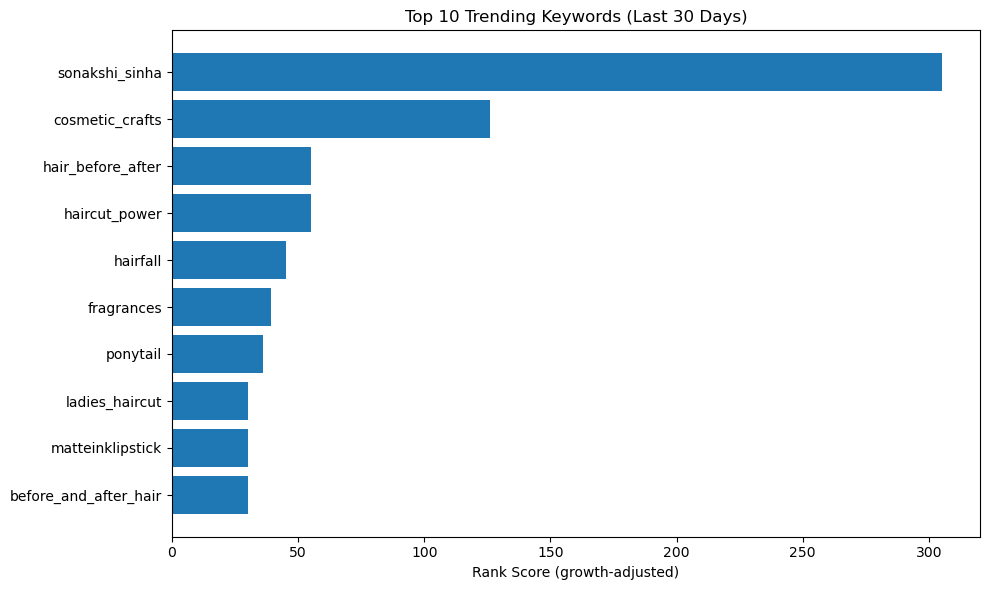

Saved: trendspotter_outputs\top10_trending_bar.png


In [23]:

top10 = top_trends[["token","rank_score"]].iloc[::-1]
plt.figure(figsize=(10,6))
plt.barh(top10["token"], top10["rank_score"])
plt.title("Top 10 Trending Keywords (Last 30 Days)")
plt.xlabel("Rank Score (growth-adjusted)")
plt.tight_layout()
bar_path = OUT_DIR / "top10_trending_bar.png"
plt.savefig(bar_path, dpi=150)
plt.show()
print("Saved:", bar_path)


## 4) Segment Mapping & Distribution

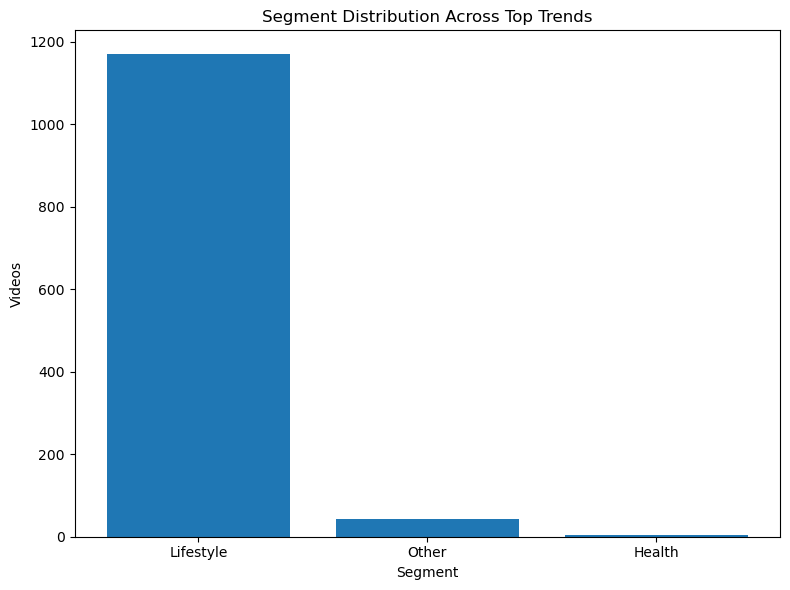

Saved: trendspotter_outputs\segment_distribution_bar.png | CSV: trendspotter_outputs\segment_distribution_top_trends_overall.csv


,segment,videos
1,Lifestyle,1169
2,Other,43
0,Health,5


In [25]:

def map_segment(topic_str):
    s = str(topic_str).lower()
    if "beauty" in s or "cosmetics" in s or "makeup" in s or "skin_care" in s or "hairstyle" in s:
        return "Beauty"
    if "lifestyle" in s or "fashion" in s or "food" in s:
        return "Lifestyle"
    if "sports" in s or "game" in s or "athletics" in s:
        return "Sports"
    if "health" in s or "fitness" in s or "medicine" in s:
        return "Health"
    return "Other"

exploded["segment"] = exploded["topicCategories"].apply(map_segment)

top_tokens = set(top_trends["token"])
seg_dist = (exploded[exploded["token"].isin(top_tokens)]
            .groupby(["segment"]).size().reset_index(name="videos")
            .sort_values("videos", ascending=False))

seg_dist_path = OUT_DIR / "segment_distribution_top_trends_overall.csv"
seg_dist.to_csv(seg_dist_path, index=False)

plt.figure(figsize=(8,6))
plt.bar(seg_dist["segment"], seg_dist["videos"])
plt.title("Segment Distribution Across Top Trends")
plt.xlabel("Segment")
plt.ylabel("Videos")
plt.tight_layout()
seg_bar_path = OUT_DIR / "segment_distribution_bar.png"
plt.savefig(seg_bar_path, dpi=150)
plt.show()

print("Saved:", seg_bar_path, "| CSV:", seg_dist_path)
seg_dist


## Audio-Language Trends (no transcripts)
We don’t have audio transcripts in the dataset, so we use **defaultAudioLanguage** (falling back to **defaultLanguage**) as an audio signal. This shows **which audio languages are accelerating** and the **audio-language mix** behind a specific trend.


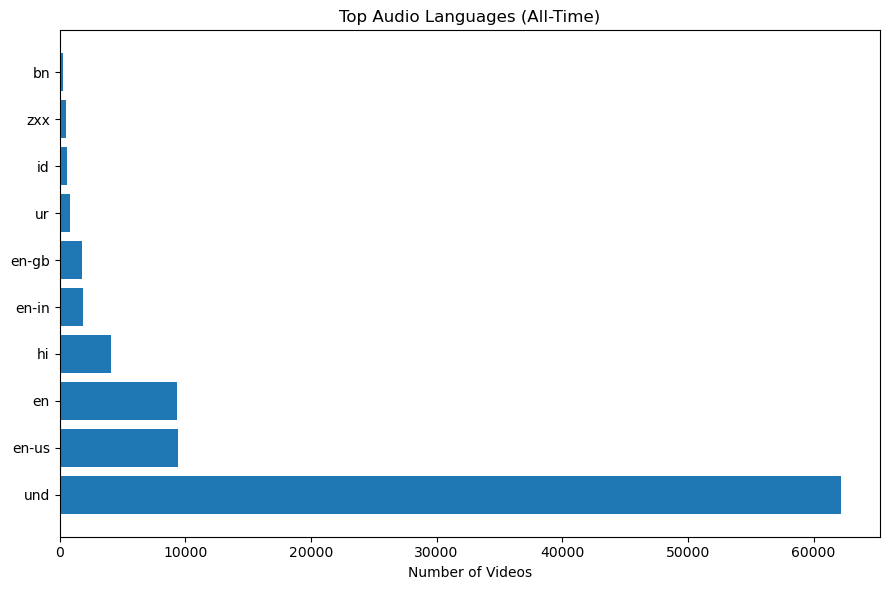

,audio_lang,videos
92,und,62177
29,en-us,9390
23,en,9341
46,hi,4094
28,en-in,1829
26,en-gb,1759
93,ur,858
52,id,584
105,zxx,510
13,bn,252


In [67]:
# --- Overall Audio Language Distribution (all-time, no 30-day window)

# Normalize codes again (if not already done)
df["defaultLanguage"] = df["defaultLanguage"].fillna("und").astype(str).str.lower()
df["defaultAudioLanguage"] = df["defaultAudioLanguage"].fillna("und").astype(str).str.lower()

df["audio_lang"] = np.where(
    df["defaultAudioLanguage"].ne("und"),
    df["defaultAudioLanguage"],
    df["defaultLanguage"]
)

# Count total videos by audio language
audlang_total = (df.groupby("audio_lang")["videoId"]
                   .nunique()
                   .reset_index(name="videos")
                   .sort_values("videos", ascending=False))

# Show top 10 languages overall
audlang_top_all = audlang_total.head(10)

plt.figure(figsize=(9,6))
plt.barh(audlang_top_all["audio_lang"], audlang_top_all["videos"])
plt.title("Top Audio Languages (All-Time)")
plt.xlabel("Number of Videos")
plt.tight_layout()
plt.show()

display(audlang_top_all)


audio_lang,ar,bn,en,en-gb,en-in,en-us,fil,hi,hi-latn,id,...,ta,tl,tr,uk,und,ur,vi,zh-hans,zh-hk,zxx
token,,,,,,,,,,,,,,,,,,,,,
before_and_after_hair,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,9,1,0,0,0,0
cosmetic_crafts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,52,0,0,0,0,0
fragrances,0,0,78,1,4,21,1,6,0,0,...,0,1,0,0,175,1,1,0,0,3
hair_before_after,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
haircut_power,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hairfall,0,1,41,6,27,9,0,32,1,0,...,2,0,1,0,127,5,0,1,0,3
ladies_haircut,0,1,0,0,0,20,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
matteinklipstick,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,9,0,0,0,0,0
ponytail,1,0,92,8,8,33,0,11,0,2,...,2,0,0,1,248,2,0,0,3,4


audio_lang,ar,bn,en,en-gb,en-in,en-us,fil,hi,hi-latn,id,...,ta,tl,tr,uk,und,ur,vi,zh-hans,zh-hk,zxx
token,,,,,,,,,,,,,,,,,,,,,
before_and_after_hair,0.000,0.000,0.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.750,0.083,0.000,0.000,0.000,0.000
cosmetic_crafts,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
fragrances,0.000,0.000,0.267,0.003,0.014,0.072,0.003,0.021,0.000,0.000,...,0.000,0.003,0.000,0.000,0.599,0.003,0.003,0.000,0.000,0.010
hair_before_after,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
haircut_power,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
hairfall,0.000,0.004,0.159,0.023,0.105,0.035,0.000,0.124,0.004,0.000,...,0.008,0.000,0.004,0.000,0.492,0.019,0.000,0.004,0.000,0.012
ladies_haircut,0.000,0.043,0.000,0.000,0.000,0.870,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000
matteinklipstick,0.000,0.000,0.000,0.000,0.000,0.091,0.000,0.091,0.000,0.000,...,0.000,0.000,0.000,0.000,0.818,0.000,0.000,0.000,0.000,0.000
ponytail,0.002,0.000,0.221,0.019,0.019,0.079,0.000,0.026,0.000,0.005,...,0.005,0.000,0.000,0.002,0.595,0.005,0.000,0.000,0.007,0.010


Top audio languages for 'sonakshi_sinha':


,token,audio_lang,videos
57,sonakshi_sinha,und,103
56,sonakshi_sinha,hi,15
55,sonakshi_sinha,en-us,4
52,sonakshi_sinha,en,2
53,sonakshi_sinha,en-gb,1


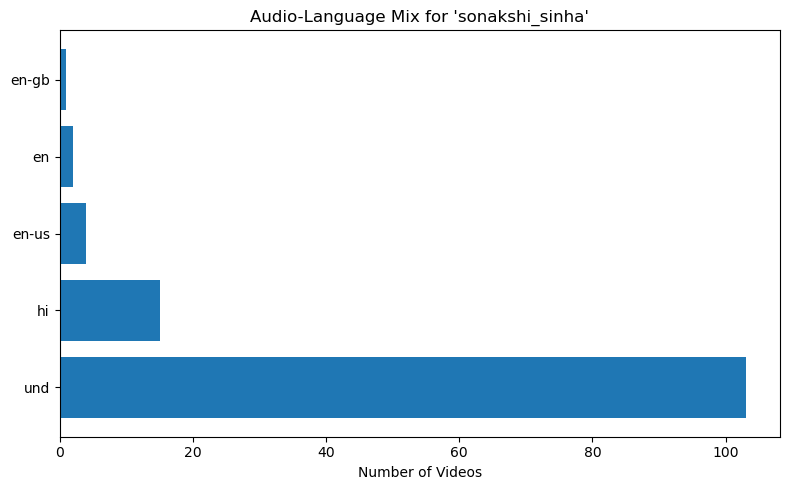

In [69]:
# --- Token × Audio Language Crosstab
# Merge token table with audio_lang
expl_lang = exploded.merge(df[["videoId","audio_lang"]], on="videoId", how="left")

# Focus on top trending tokens only
top_tokens = top_trends["token"].tolist()
cross = (expl_lang[expl_lang["token"].isin(top_tokens)]
         .groupby(["token","audio_lang"]).size()
         .reset_index(name="videos"))

# Pivot into matrix form (tokens × languages)
matrix = cross.pivot(index="token", columns="audio_lang", values="videos").fillna(0).astype(int)

# Normalize by row (optional: % share per token)
matrix_pct = matrix.div(matrix.sum(axis=1), axis=0).round(3)

display(matrix.head(10))
display(matrix_pct.head(10))

# Example: show token vs top 5 languages
best_token = top_trends.loc[0,"token"]
mix = (cross[cross["token"]==best_token]
       .sort_values("videos", ascending=False).head(5))
print(f"Top audio languages for '{best_token}':")
display(mix)

# Chart: language mix for #1 token
plt.figure(figsize=(8,5))
plt.barh(mix["audio_lang"], mix["videos"])
plt.title(f"Audio-Language Mix for '{best_token}'")
plt.xlabel("Number of Videos")
plt.tight_layout()
plt.show()


## 5) Decay Analysis for #1 Trend

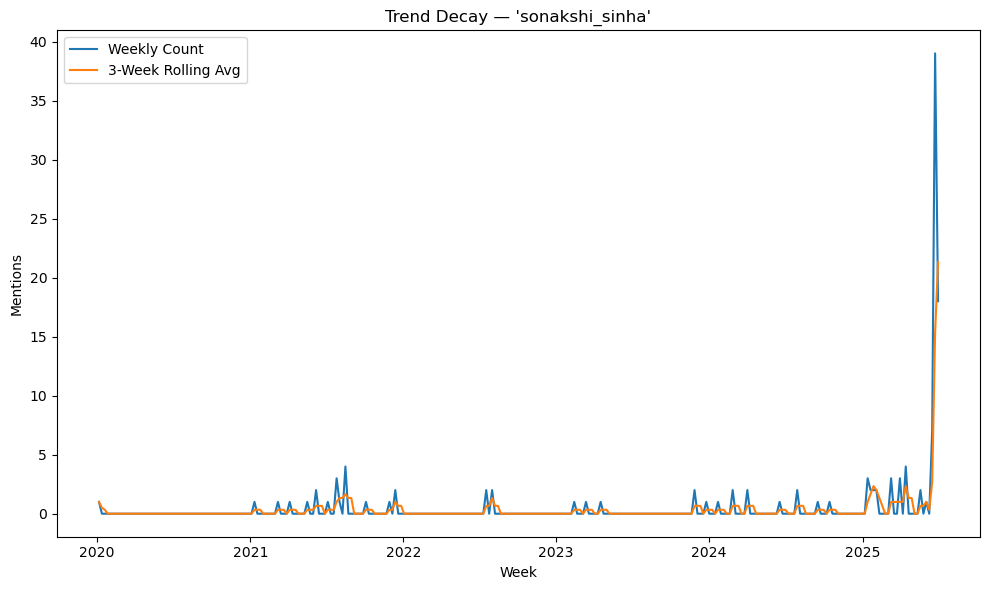

Saved: trendspotter_outputs\decay_sonakshi_sinha.png


In [27]:

if len(top_trends) > 0:
    best_token = top_trends.loc[0, "token"]
    series = (weekly_counts[weekly_counts["token"] == best_token]
              .sort_values("week").set_index("week")["count"]
              .asfreq("W-MON", fill_value=0))
    rolling = series.rolling(3, min_periods=1).mean()

    peak = rolling.max()
    decay_point = None
    below = rolling < (0.6 * peak)
    if peak > 0:
        peaked_idx = rolling.idxmax()
        after_peak = rolling[rolling.index > peaked_idx]
        for ts in after_peak.index:
            if below.get(ts, False) and below.shift(1).get(ts, False):
                decay_point = ts
                break

    plt.figure(figsize=(10,6))
    plt.plot(series.index, series.values, label="Weekly Count")
    plt.plot(rolling.index, rolling.values, label="3-Week Rolling Avg")
    if decay_point is not None:
        plt.axvline(decay_point, linestyle="--", label=f"Decay Point ({decay_point.date()})")
    plt.title(f"Trend Decay — '{best_token}'")
    plt.xlabel("Week"); plt.ylabel("Mentions"); plt.legend()
    plt.tight_layout()
    decay_path = OUT_DIR / f"decay_{best_token}.png"
    plt.savefig(decay_path, dpi=150)
    plt.show()
    print("Saved:", decay_path)
else:
    print("No trends found.")


## 6) Enhancement: Momentum Score (Engagement-weighted)

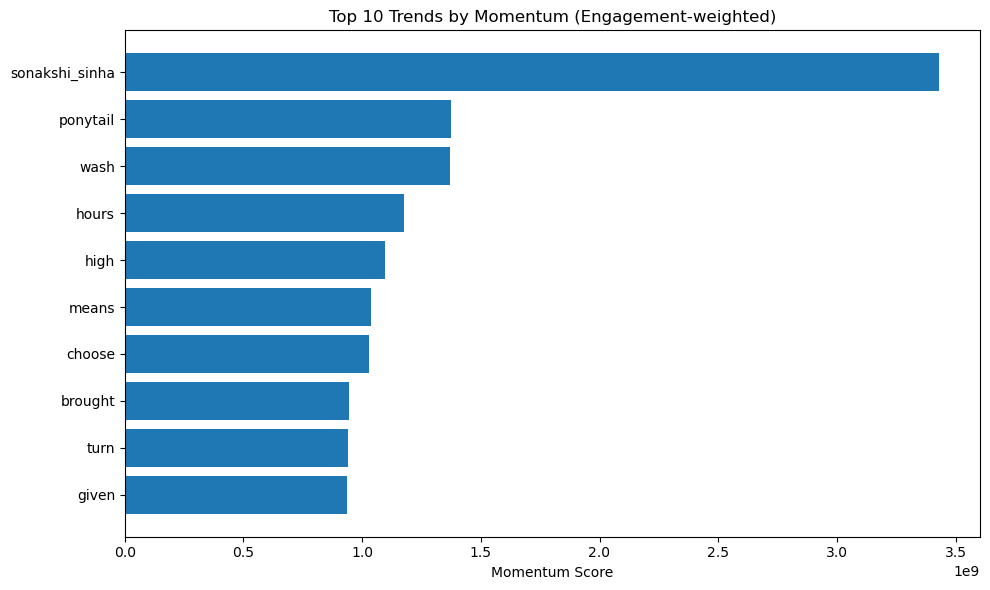

Saved: trendspotter_outputs\top_trending_keywords_momentum.csv | trendspotter_outputs\top10_trending_momentum_bar.png


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score,viewCount,likeCount,commentCount,momentum_score
0,sonakshi_sinha,64,3.0,61.0,21.333333,305.000000,3.446203e+08,11249752.0,57229.0,3.431175e+09
1,ponytail,18,6.0,12.0,3.000000,36.000000,1.131010e+09,38143446.0,289385.0,1.373164e+09
2,wash,84,76.0,8.0,1.105263,8.842105,4.959085e+09,154813643.0,1309021.0,1.368879e+09
3,hours,41,33.0,8.0,1.242424,9.939394,3.591173e+09,118500127.0,963932.0,1.177819e+09
4,high,57,50.0,7.0,1.140000,7.980000,4.387717e+09,137623422.0,1308694.0,1.098235e+09
5,means,36,30.0,6.0,1.200000,7.200000,4.538504e+09,144267425.0,1599494.0,1.038725e+09
6,choose,25,18.0,7.0,1.388889,9.722222,3.107563e+09,105820103.0,1476163.0,1.028807e+09
7,brought,9,3.0,6.0,3.000000,18.000000,1.470394e+09,52430968.0,465437.0,9.437574e+08
8,turn,32,26.0,6.0,1.230769,7.384615,4.372091e+09,127089009.0,1249483.0,9.385035e+08
9,given,16,7.0,9.0,2.285714,20.571429,1.413948e+09,45439278.0,503584.0,9.347509e+08


In [29]:

# Aggregate engagement per token (sum of views/likes/comments over the whole dataset window)
eng = (exploded.groupby("token")[["viewCount","likeCount","commentCount"]]
              .sum().fillna(0).reset_index())

trend_m = trend.merge(eng, on="token", how="left").fillna(0)
# Simple momentum: rank_score * (likes + 1) to avoid zeroing
trend_m["momentum_score"] = trend_m["rank_score"] * (trend_m["likeCount"] + 1)

top_trends_momentum = trend_m.sort_values("momentum_score", ascending=False).head(10).reset_index(drop=True)
top_trends_momentum_path = OUT_DIR / "top_trending_keywords_momentum.csv"
top_trends_momentum.to_csv(top_trends_momentum_path, index=False)

# Chart
top10m = top_trends_momentum[["token","momentum_score"]].iloc[::-1]
plt.figure(figsize=(10,6))
plt.barh(top10m["token"], top10m["momentum_score"])
plt.title("Top 10 Trends by Momentum (Engagement-weighted)")
plt.xlabel("Momentum Score")
plt.tight_layout()
mom_bar_path = OUT_DIR / "top10_trending_momentum_bar.png"
plt.savefig(mom_bar_path, dpi=150)
plt.show()

print("Saved:", top_trends_momentum_path, "|", mom_bar_path)
top_trends_momentum


## 7) Enhancement: Segment Drill-Down Helper

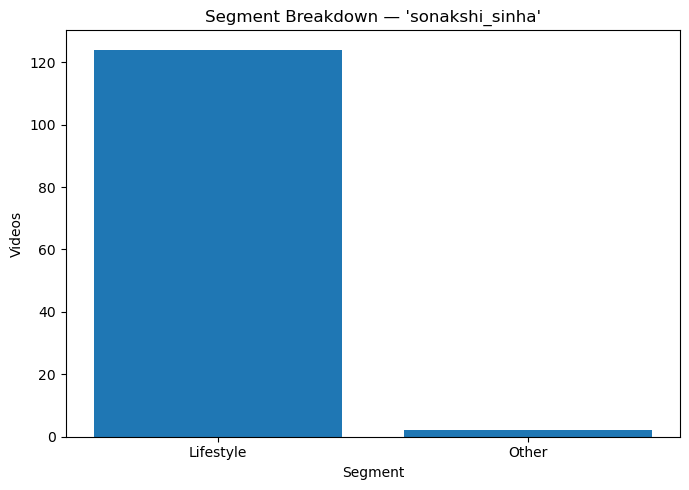

Saved: trendspotter_outputs\segment_breakdown_sonakshi_sinha.png


In [31]:

def segment_breakdown_for(token):
    sub = exploded[exploded["token"] == token]
    if sub.empty:
        return pd.DataFrame(columns=["segment","videos"])
    dist = (sub.groupby("segment").size().reset_index(name="videos")
              .sort_values("videos", ascending=False))
    # Plot
    plt.figure(figsize=(7,5))
    plt.bar(dist["segment"], dist["videos"])
    plt.title(f"Segment Breakdown — '{token}'")
    plt.xlabel("Segment"); plt.ylabel("Videos"); plt.tight_layout()
    path = OUT_DIR / f"segment_breakdown_{token}.png"
    plt.savefig(path, dpi=150)
    plt.show()
    print("Saved:", path)
    return dist

# Example usage with best token
if len(top_trends) > 0:
    _ = segment_breakdown_for(top_trends.loc[0, "token"])


## 8) Enhancement: DL Mode — Semantic Topic Clustering (Transformer -> KMeans)

DL Mode: Using SentenceTransformer embeddings + KMeans


C:\Users\lunwe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


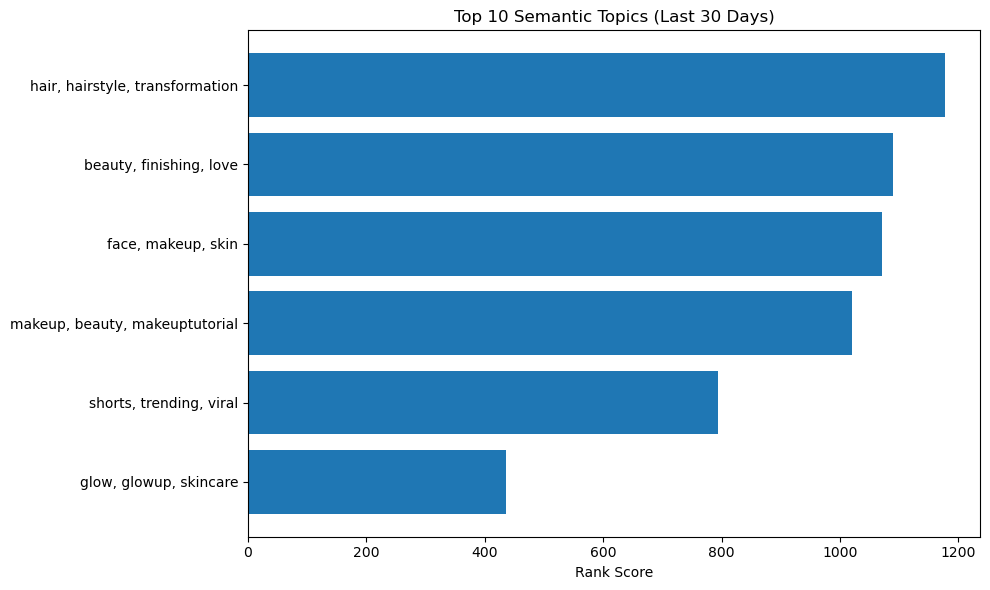

Saved: trendspotter_outputs\top_topics_semantic.csv | trendspotter_outputs\top10_topics_semantic_bar.png


In [33]:
if "published_local_naive" not in df.columns:
    df["published_local_naive"] = (
        df["publishedAt_local"]
        .dt.tz_convert("Asia/Kuala_Lumpur")  # ensure consistent tz
        .dt.tz_localize(None)                # drop tz -> naive
    )

# 1) Recompute time windows in naive time to avoid tz-aware vs naive comparison errors
end_date     = df["published_local_naive"].max().normalize() + pd.Timedelta(days=1)
start_recent = end_date - pd.Timedelta(days=30)
start_prev   = start_recent - pd.Timedelta(days=30)

# 2) Filter recent titles (naive mask)
recent_mask   = (df["published_local_naive"] >= start_recent) & (df["published_local_naive"] < end_date)
titles_recent = df.loc[recent_mask, "title"].dropna().astype(str)

if len(titles_recent) < 50:
    print("DL Mode: Not enough recent titles for clustering (<50). Skipping.")
else:
    df_recent = None  # will hold titles + topic_label + week

    if HAS_ST and HAS_SK:
        print("DL Mode: Using SentenceTransformer embeddings + KMeans")
        try:
            from sentence_transformers import SentenceTransformer
            from sklearn.cluster import KMeans
            from sklearn.metrics import silhouette_score

            # Sample to keep fast if dataset is large
            titles_sample = titles_recent.sample(min(5000, len(titles_recent)), random_state=42)

            # Embeddings
            model = SentenceTransformer("all-MiniLM-L6-v2")
            X = model.encode(titles_sample.tolist(), normalize_embeddings=True)

            # Choose k with a tiny sweep
            best_k, best_score, best_km = None, -1, None
            for k in [6, 8, 10, 12]:
                km = KMeans(n_clusters=k, n_init=10, random_state=42)
                labels_try = km.fit_predict(X)
                # Some setups may fail silhouette on big N; guard it
                try:
                    score = silhouette_score(X, labels_try)
                except Exception:
                    score = -1
                if score > best_score:
                    best_k, best_score, best_km = k, score, km

            # Label sample points
            labels = best_km.predict(X)

            # Build simple topic labels from frequent words
            import collections
            def words(s): return re.findall(r"[A-Za-z][A-Za-z0-9_]+", s.lower())
            stop = set("""a an the and or for of to in on with by from this that those these it its as if but so not no you your our their my me we us i they he she them him her than then there here when where how what which who is are was were be been being""".split())

            cluster_titles = pd.DataFrame({"title": titles_sample.values, "cluster": labels})
            topic_labels = {}
            for c, grp in cluster_titles.groupby("cluster"):
                cnt = collections.Counter(w for t in grp["title"] for w in words(t) if len(w)>=3 and w not in stop)
                common = [w for w,_ in cnt.most_common(5)]
                topic_labels[c] = ", ".join(common[:3]) if common else f"topic_{c}"

            # Map all recent titles to nearest cluster
            df_recent = df.loc[recent_mask, ["videoId", "title", "published_local_naive"]].dropna().copy()
            Z = model.encode(df_recent["title"].tolist(), normalize_embeddings=True)
            cluster_ids = best_km.predict(Z)
            df_recent["topic_label"] = [topic_labels.get(c, f"topic_{c}") for c in cluster_ids]

        except Exception as e:
            print("DL Mode transformer path failed; falling back to TF-IDF. Error:", e)
            HAS_ST = False  # trigger fallback

    if (not HAS_ST) and HAS_SK:
        print("DL Mode Fallback: TF-IDF + KMeans")
        from sklearn.cluster import KMeans
        from sklearn.feature_extraction.text import TfidfVectorizer

        titles_sample = titles_recent  # use all recent titles
        vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=3)
        X = vec.fit_transform(titles_sample)
        km = KMeans(n_clusters=10, n_init=10, random_state=42).fit(X)
        labels = km.labels_

        df_recent = pd.DataFrame({
            "title": titles_sample.values,
            "published_local_naive": df.loc[recent_mask, "published_local_naive"].values[:len(titles_sample)]
        })
        df_recent["topic_label"] = labels.astype(str)

    # 3) Compute topic weekly counts + rank
    if isinstance(df_recent, pd.DataFrame) and not df_recent.empty:
        df_recent["week"] = df_recent["published_local_naive"].dt.to_period("W").apply(lambda p: p.start_time)

        topic_weekly = (df_recent.groupby(["week", "topic_label"])
                        .size().reset_index(name="count")
                        .sort_values(["topic_label","week"]))

        def window_sum_topic(dfc, start, end):
            m = (dfc["week"] >= start) & (dfc["week"] < end)
            return (dfc[m].groupby("topic_label")["count"].sum().rename("count").reset_index())

        topic_recent = window_sum_topic(topic_weekly, start_recent, end_date)
        topic_prev   = window_sum_topic(topic_weekly, start_prev, start_recent)

        topic_trend = (topic_recent.merge(topic_prev, on="topic_label", how="left", suffixes=("_recent","_prev"))
                                  .fillna({"count_prev": 0}))
        topic_trend["growth_abs"]  = topic_trend["count_recent"] - topic_trend["count_prev"]
        topic_trend["growth_rate"] = topic_trend.apply(
            lambda r: (r["count_recent"]/r["count_prev"]) if r["count_prev"]>0 else (np.inf if r["count_recent"]>0 else 0),
            axis=1
        )
        topic_trend = topic_trend[topic_trend["count_recent"] >= 5].copy()
        topic_trend["rank_score"] = topic_trend["growth_abs"] * np.where(
            np.isinf(topic_trend["growth_rate"]), 3, np.minimum(topic_trend["growth_rate"], 5)
        )
        top_topics = topic_trend.sort_values(["rank_score","count_recent"], ascending=[False, False]).head(10)

        # Save CSV + chart
        topic_trend_path = OUT_DIR / "top_topics_semantic.csv"
        top_topics.to_csv(topic_trend_path, index=False)

        t10 = top_topics[["topic_label","rank_score"]].iloc[::-1]
        plt.figure(figsize=(10,6))
        plt.barh(t10["topic_label"], t10["rank_score"])
        plt.title("Top 10 Semantic Topics (Last 30 Days)")
        plt.xlabel("Rank Score")
        plt.tight_layout()
        sem_bar_path = OUT_DIR / "top10_topics_semantic_bar.png"
        plt.savefig(sem_bar_path, dpi=150)
        plt.show()

        print("Saved:", topic_trend_path, "|", sem_bar_path)
    else:
        print("DL Mode skipped or failed; no semantic topics produced.")


# Hybrid Model

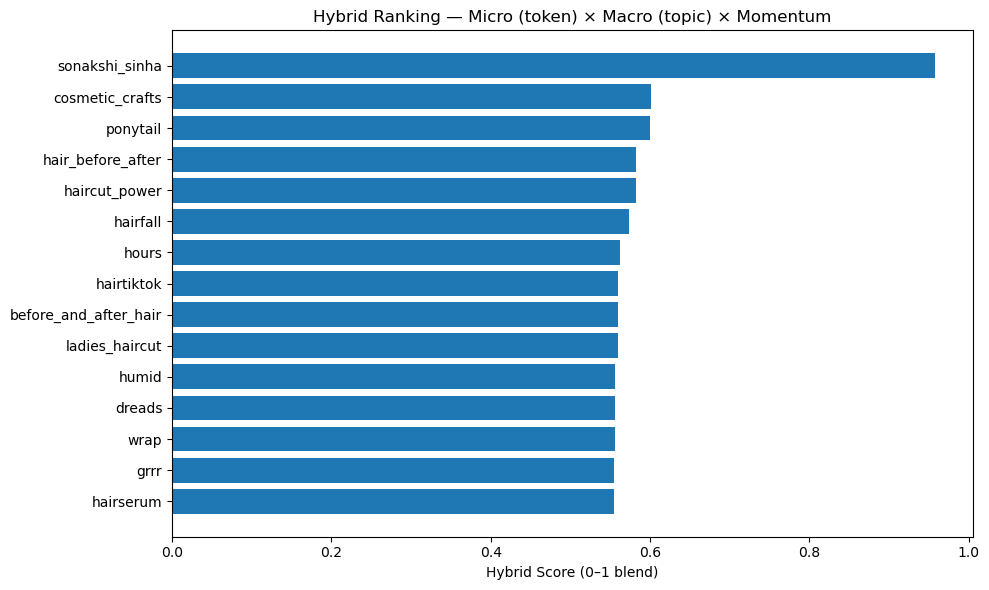

Hybrid chart saved: trendspotter_outputs\hybrid_top15.png


,token,mapped_topic,token_score,topic_score,mom_score,hybrid_score
2943,sonakshi_sinha,"makeup, beauty, makeuptutorial",1.000000,0.787771,1.000000,0.957554
681,cosmetic_crafts,"makeup, beauty, makeuptutorial",0.739775,0.787771,0.000000,0.601419
2488,ponytail,"hair, hairstyle, transformation",0.608935,1.000000,0.175617,0.600484
1379,hair_before_after,"hair, hairstyle, transformation",0.636557,1.000000,0.000000,0.581934
1408,haircut_power,"hair, hairstyle, transformation",0.636557,1.000000,0.000000,0.581934
1417,hairfall,"hair, hairstyle, transformation",0.622019,1.000000,0.000000,0.573212
1555,hours,"hair, hairstyle, transformation",0.571049,1.000000,0.097367,0.562103
1435,hairtiktok,"hair, hairstyle, transformation",0.600213,1.000000,0.000000,0.560128
296,before_and_after_hair,"hair, hairstyle, transformation",0.600213,1.000000,0.000000,0.560128
1806,ladies_haircut,"hair, hairstyle, transformation",0.600213,1.000000,0.000000,0.560128


In [35]:
# --- HYBRID: micro (tokens) × macro (semantic topics) × momentum ---

if 'df_recent' not in locals() or df_recent is None or df_recent.empty:
    print("Hybrid: needs DL Mode output (df_recent with topic_label). Run DL Mode first.")
else:
    # Ensure tz-naive time used consistently (same as DL Mode)
    if "published_local_naive" not in df.columns:
        df["published_local_naive"] = df["publishedAt_local"].dt.tz_localize(None)

    mask_recent = (df["published_local_naive"] >= start_recent) & (df["published_local_naive"] < end_date)

    # Carry videoId so we can merge robustly (avoid fragile title-based join)
    recent_exploded = (
        df.loc[mask_recent, ["videoId", "title", "tokens", "publishedAt_local"]]
          .explode("tokens")
          .rename(columns={"tokens": "token"})
          .dropna(subset=["videoId", "token"])
          .copy()
    )

    # token normalization (same rules)
    def unify_token(t):
        unify_map = {
            r"^sonakshi\s*sinha$|^sonakshisinha$|^sonakshi$|^sinha$": "sonakshi_sinha",
            r"^cosmetic\s*crafts$|^cosmeticcrafts$": "cosmetic_crafts",
            r"^haircut\s*power$": "haircut_power",
            r"^hair\s*before\s*after$": "hair_before_after",
        }
        t = str(t)
        for pattern, repl in unify_map.items():
            if re.match(pattern, t):
                return repl
        return re.sub(r"\s+", "_", t)

    recent_exploded["token"] = (
        recent_exploded["token"].astype(str)
        .str.replace("^#", "", regex=True)
        .apply(unify_token)
    )
    recent_exploded = recent_exploded[recent_exploded["token"].str.len() >= 3]
    recent_exploded = recent_exploded.drop_duplicates(["videoId", "token"])  # avoid double-counts

    # Map TOKENS -> most common TOPIC via videoId (robust to translation/title edits)
    # Ensure df_recent includes videoId when you build it in DL Mode:
    # df_recent = df.loc[recent_mask, ["videoId","title","published_local_naive"]].copy()
    # df_recent["topic_label"] = ... (as you already compute)
    recent_titles = df_recent[["videoId", "topic_label"]].dropna().copy()

    tok_topic = (
        recent_exploded.merge(recent_titles, on="videoId", how="inner")
        .groupby(["token", "topic_label"]).size().reset_index(name="n")
        .sort_values(["token", "n"], ascending=[True, False])
        .drop_duplicates("token")
        .rename(columns={"topic_label": "mapped_topic", "n": "cooccurrences"})
    )

    # Normalize helper
    def norm01(s):
        s = s.astype(float)
        if s.empty:
            return s  # empty -> empty
        lo, hi = s.min(), s.max()
        return pd.Series(0.5, index=s.index) if hi == lo else (s - lo) / (hi - lo)

    # Token scores from your trend table
    token_scores = trend[["token", "rank_score"]].copy()
    token_scores["token_score"] = norm01(token_scores["rank_score"])
    token_scores = token_scores.drop(columns=["rank_score"])

    # Topic scores from DL Mode
    topic_scores = top_topics[["topic_label", "rank_score"]].copy()
    topic_scores["topic_score"] = norm01(topic_scores["rank_score"])
    topic_scores = topic_scores.rename(columns={"topic_label": "mapped_topic"}).drop(columns=["rank_score"])

    # Momentum (if available)
    if 'top_trends_momentum' in locals():
        mom = top_trends_momentum[["token", "momentum_score"]].copy()
        mom["mom_score"] = norm01(mom["momentum_score"])
        mom = mom[["token", "mom_score"]]
    else:
        mom = pd.DataFrame(columns=["token", "mom_score"])

    # Weights
    alpha = 0.6  # token (micro)
    beta  = 0.2  # momentum
    topic_weight = max(0.0, 1.0 - alpha - beta)  # topic (macro)

    # Blend
    hybrid = (token_scores
              .merge(tok_topic[["token", "mapped_topic"]], on="token", how="left")
              .merge(topic_scores, on="mapped_topic", how="left")
              .merge(mom, on="token", how="left")
              .fillna({"topic_score": 0.0, "mom_score": 0.0}))

    hybrid["hybrid_score"] = (
        alpha * hybrid["token_score"]
        + topic_weight * hybrid["topic_score"]
        + beta * hybrid["mom_score"]
    )

    hybrid_ranked = hybrid.sort_values("hybrid_score", ascending=False).head(15)

    # Plot + save
    plt.figure(figsize=(10, 6))
    h10 = hybrid_ranked[["token", "hybrid_score"]].iloc[::-1]
    plt.barh(h10["token"], h10["hybrid_score"])
    plt.title("Hybrid Ranking — Micro (token) × Macro (topic) × Momentum")
    plt.xlabel("Hybrid Score (0–1 blend)")
    plt.tight_layout()
    hybrid_path = OUT_DIR / "hybrid_top15.png"
    plt.savefig(hybrid_path, dpi=150)
    plt.show()

    print("Hybrid chart saved:", hybrid_path)
    display(hybrid_ranked[["token", "mapped_topic", "token_score", "topic_score", "mom_score", "hybrid_score"]])

### Mode Summary


## Evaluation (Quick Metrics)


In [38]:
import numpy as np
BEAUTY_TERMS = set('hair haircut hairstyle ponytail dye scalp hairfall skin skincare glow matte lipstick mascara foundation toner serum cleanser makeup fragrance perfume eau nail mani pedi brow lash contour blush highlight retinol hyaluronic'.split())
def is_beauty_token(tok: str):
    t = str(tok).lower()
    return any(w in t for w in BEAUTY_TERMS)
def precision_at_k(tokens, k=10):
    if not tokens:
        print('Precision@K: N/A (no tokens)'); return np.nan
    topk = tokens[:k]
    rel = sum(is_beauty_token(t) for t in topk)
    p = rel/len(topk)
    print('Beauty Precision@{}:'.format(k), p); return p
try:
    top_tokens_list = top_trends['token'].tolist()
except Exception:
    top_tokens_list = []
precision_at_k(top_tokens_list, 10)
try:
    if len(top_trends)>0:
        best_token = top_trends.loc[0, 'token']
        series = (weekly_counts[weekly_counts['token']==best_token]
                    .sort_values('week').set_index('week')['count'])
        if len(series)>0:
            first_week = series.index.min(); peak_week = series.idxmax()
            lead_weeks = (peak_week - first_week).days/7
            print(f"Lead time for '{best_token}': {lead_weeks:.1f} weeks")
        else:
            print('Lead time: N/A')
    else:
        print('Lead time: N/A (no trends)')
except Exception as e:
    print('Lead time: N/A', e)


Beauty Precision@10: 0.8
Lead time for 'sonakshi_sinha': 285.0 weeks


In [59]:
def lead_time_weeks(token, weekly_counts, months=12):
    s = (weekly_counts[weekly_counts["token"]==token]
         .sort_values("week").set_index("week")["count"])
    if s.empty: return np.nan
    cutoff = s.index.max() - pd.DateOffset(months=months)
    s_recent = s[s.index >= cutoff]
    if s_recent.empty: return np.nan
    first_week = s_recent.index.min()
    peak_week  = s_recent.idxmax()
    return (peak_week - first_week).days / 7

try:
    best = top_trends.loc[0, "token"]
    lt_all = lead_time_weeks(best, weekly_counts, months=120)  # raw (10y cap)
    lt_12m = lead_time_weeks(best, weekly_counts, months=12)   # adjusted
    print(f"Lead time (raw) for '{best}': {lt_all:.1f} wks")
    print(f"Lead time (last 12m) for '{best}': {lt_12m:.1f} wks")
except Exception as e:
    print("Lead time calc error:", e)

Lead time (raw) for 'sonakshi_sinha': 285.0 wks
Lead time (last 12m) for 'sonakshi_sinha': 47.0 wks
